In [1]:
import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

print(common_variable.sections())
print(common_variable['database']['module_path'])
print(common_variable['database']['DB_BASE'])

import sys
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *

import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from parse import parse
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from glob import glob
from tqdm import tqdm_notebook

['database', 'mlflow', 'font']
/media/myungsungkwak/msdisk/docrv2_sroie/modules/database/
/media/myungsungkwak/msdisk/docrv2_data/DB/


In [2]:
def create_database(db_idx, db_name=None):
    path = common_variable['database']['DB_BASE']
    os.makedirs(path, exist_ok=True)

    name = db_name + "_%04d"%db_idx
    description = 'data db from train_task2 all coords images'
    datadb = create_data_db(path=path, name=name, description=description, data_class='DATA')
    print("... created db : ", name)
    return datadb

def update_database(datadb, imgs, coords, refname, db_start_idx):
    for idx, img in enumerate(imgs):
        chars = []
        chars.append(coords[idx][8])
        char_table = pd.DataFrame(coords[idx])
        char_table = char_table.T
        char_table.rename(columns={0:'x1', 1:'y1', 2:'x2', 3:'y2', 4:'x3',
                                   5:'y3', 6:'x4', 7:'y4', 8:'char'}, inplace=True)
        
        char_table.x1 = char_table.x1.astype(int)
        char_table.y1 = char_table.y1.astype(int)
        char_table.x2 = char_table.x2.astype(int)
        char_table.y2 = char_table.y2.astype(int)
        char_table.x3 = char_table.x3.astype(int)
        char_table.y3 = char_table.y3.astype(int)
        char_table.x4 = char_table.x4.astype(int)
        char_table.y4 = char_table.y4.astype(int)
        
        update_data(datadb, index=db_start_idx+idx, label='task12', image=img, text=chars[0], ref=refname)

def get_coords_from_image(txt_file):
    lps = []

    try:
        with open(txt_file, 'r') as f:
            coords_data = f.read().split('\n')
            for ii in range(len(coords_data)):
                if len(coords_data[ii]) > 0:
                    ps = parse('{},{},{},{},{},{},{},{},{}', coords_data[ii])
                    ps = list(ps)
                    ps[:-1] = list(map(int, ps[:-1]))
                    lps.append(ps)
    except:
        with open(txt_file, 'r', encoding='ISO-8859-1') as f:
            coords_data = f.read().split('\n')
            for ii in range(len(coords_data)):
                if len(coords_data[ii]) > 0:
                    ps = parse('{},{},{},{},{},{},{},{},{}', coords_data[ii])
                    ps = list(ps)
                    ps[:-1] = list(map(int, ps[:-1]))
                    lps.append(ps)
    return lps

In [3]:
"""
method 1 - no padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords(img_path, coords, num_images=1):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]
    
    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords)) 
    transpose_y1_coords = list(map(int, transpose_y1_coords))
    
    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords)) 
    transpose_y2_coords = list(map(int, transpose_y2_coords))    
    
    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords)) 
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords)) 
    transpose_y4_coords = list(map(int, transpose_y4_coords))
    
    transpose_chars = np.transpose(coords)[8]
    
    sample_list = []
    coords_list = []
    for idx in range(num_images):
        base_idx = idx

        new_x1 = transpose_x1_coords[base_idx]
        new_y1 = transpose_y1_coords[base_idx]

        new_x2 = transpose_x2_coords[base_idx]
        new_y2 = transpose_y2_coords[base_idx]

        new_x3 = transpose_x3_coords[base_idx]
        new_y3 = transpose_y3_coords[base_idx]

        new_x4 = transpose_x4_coords[base_idx]
        new_y4 = transpose_y4_coords[base_idx]
    
        crop_img = img.crop((new_x1,
                             new_y1,
                             new_x3,
                             new_y3))
        sample_list.append(crop_img)
        coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                           transpose_chars[base_idx]])

    return sample_list, coords_list

In [21]:
"""
method 2 - random size padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords_pad_random(img_path, coords, num_images=1):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]

    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords))
    transpose_y1_coords = list(map(int, transpose_y1_coords))

    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords))
    transpose_y2_coords = list(map(int, transpose_y2_coords))

    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords))
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords))
    transpose_y4_coords = list(map(int, transpose_y4_coords))

    transpose_chars = np.transpose(coords)[8]
    
    sample_list = []
    coords_list = []
    
    img_cnt = 0

    #for _ in range(np.random.randint(7, 12)):
    for _ in range(np.random.randint(10, 20)):
        # [-4  5  9  3] --> left right up bottom
        # num_images --> coords imags
        for idx in range(num_images):
            # pdd = np.random.randint(-5,10,4)
            pdd = np.random.randint(0,5,4)
            base_idx = idx
            while True:
                if (transpose_x3_coords[base_idx] - transpose_x1_coords[base_idx] <= 20) or (transpose_y3_coords[base_idx] - transpose_x1_coords[base_idx]<=20):
                    new_x1 = transpose_x1_coords[base_idx]
                    new_y1 = transpose_y1_coords[base_idx]
                    new_x2 = transpose_x2_coords[base_idx]
                    new_y2 = transpose_y2_coords[base_idx]
                    new_x3 = transpose_x3_coords[base_idx]
                    new_y3 = transpose_y3_coords[base_idx]
                    new_x4 = transpose_x4_coords[base_idx]
                    new_y4 = transpose_y4_coords[base_idx]
                    break
                else:
                    new_x1 = transpose_x1_coords[base_idx] - pdd[0] # pad left
                    new_y1 = transpose_y1_coords[base_idx] - pdd[2] # pad up

                    new_x3 = transpose_x3_coords[base_idx] + pdd[1] # pad right
                    new_y3 = transpose_y3_coords[base_idx] + pdd[3] # pad bottom

                    new_x2 = new_x3
                    new_y2 = new_y1

                    new_x4 = new_x1
                    new_y4 = new_y3

                    if (new_x1 < 0) or (new_x4 < 0) or (new_x2 > o_width) or (new_x3 > o_width):
                        print("[problem] x coords")
                        pdd = np.random.randint(-5,10,4)
                        continue
                    if (new_y1 < 0) or (new_y2 < 0) or (new_y3 > o_height) or (new_y3 > o_height):
                        print("[problem] y coords")
                        pdd = np.random.randint(-5,10,4)
                        continue
                    break

            crop_img = img.crop((new_x1, new_y1, new_x3, new_y3))
            if (crop_img.size[0]) > 0 and (crop_img.size[1] > 0):
                sample_list.append(crop_img)
                coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                                    transpose_chars[base_idx]])

                img_cnt = img_cnt + 1

    return sample_list, coords_list, img_cnt

In [5]:
"""
method 3 - fixed size padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords_pad(img_path, coords, num_images=1, pad_max=5):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]

    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords))
    transpose_y1_coords = list(map(int, transpose_y1_coords))

    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords))
    transpose_y2_coords = list(map(int, transpose_y2_coords))

    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords))
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords))
    transpose_y4_coords = list(map(int, transpose_y4_coords))

    transpose_chars = np.transpose(coords)[8]
    
    """
    pad_type
    1) left ←
    2) right →
    3) up ↑
    4) bottom ↓
    5) all ←, →, ↑, ↓
    """
    # 1~5
    # p_size = np.random.randint(1, pad_max)
    p_size = pad_max # only 5 pix
    #pad_type = ["left", "right", "up", "bottom", "all"]
    pad_type = ["all"]

    sample_list = []
    coords_list = []
    
    for pad_idx in range(len(pad_type)):
        for idx in range(num_images):
            base_idx = idx

            new_x1 = transpose_x1_coords[base_idx]
            new_y1 = transpose_y1_coords[base_idx]

            new_x2 = transpose_x2_coords[base_idx]
            new_y2 = transpose_y2_coords[base_idx]

            new_x3 = transpose_x3_coords[base_idx]
            new_y3 = transpose_y3_coords[base_idx]

            new_x4 = transpose_x4_coords[base_idx]
            new_y4 = transpose_y4_coords[base_idx]
            
            if pad_type[pad_idx] == "left":
                new_x1 = new_x1 - p_size
                new_x4 = new_x4 - p_size
            elif pad_type[pad_idx] == "right":
                new_x2 = new_x2 + p_size
                new_x3 = new_x3 + p_size
            elif pad_type[pad_idx] == "up":
                new_y1 = new_y1 - p_size
                new_y2 = new_y2 - p_size
            elif pad_type[pad_idx] == "bottom":
                new_y3 = new_y3 + p_size
                new_y4 = new_y4 + p_size
            else:
                new_x1 = new_x1 - p_size
                new_y1 = new_y1 - p_size
                
                new_x2 = new_x2 + p_size
                new_y2 = new_y2 - p_size
                
                new_x3 = new_x3 + p_size
                new_y3 = new_y3 + p_size
                
                new_x4 = new_x4 - p_size
                new_y4 = new_y4 + p_size
                
                
            crop_img = img.crop((new_x1, new_y1, new_x3, new_y3))
            sample_list.append(crop_img)
            coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                                transpose_chars[base_idx]])

    return sample_list, coords_list

In [6]:
for _ in range(10):
    pdd = np.random.randint(-3,3,4)
    print(pdd)

[ 0 -2  2 -1]
[-2 -1 -3 -3]
[-2 -3 -3 -1]
[-1 -2 -1 -2]
[-1 -1 -2 -2]
[ 1  2 -2  2]
[ 0  0 -3  1]
[-2 -3 -3 -1]
[-1 -3 -1  1]
[-2 -1 -2  2]


  0%|          | 0/361 [00:00<?, ?it/s]

... created db :  recog_test_all_pad5_valid_0001


100%|██████████| 361/361 [40:18<00:00,  6.70s/it]


In [22]:
"""
run2: create data - random size padding (use get_crop_image_by_coords_pad_random)
"""
for folder_idx in range(1):
    # datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_split_{}/'.format(folder_idx+1)
    #datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_u80_style_{}/'.format(folder_idx+1)
    # datadir = '/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_{}/'.format(folder_idx+1)
    
    #datadir = '/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_gray_style_{}/'.format(folder_idx+1)
    # datadir = '/media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0925/'
    datadir = '/media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/'
    
    print("[" + datadir + "]")
    img_files = glob(datadir+'*.jpg')
    txt_files = glob(datadir+'*.txt')

    crop_images = []
    coords_table = []

    datadb = create_database(3, "recog_train_task2_random_ppad5_u85_style2_modified")
    num_images = 1
    db_start_idx = 0
    for idx in tqdm(range(len(img_files))):
        
        refname = os.path.basename(img_files[idx])[:-4]
        txt_filepath = os.path.join(datadir, refname+'.txt')
        coords_table.append(get_coords_from_image(txt_filepath))
        
        print("> imgs : {}. {}".format(idx, img_files[idx]))
        print("> text : {}. {}".format(idx, txt_filepath))

        num_images = len(coords_table[idx])

        # crop_img, crop_coords = get_crop_image_by_coords(img_files[idx], coords_table[idx], num_images=num_images)
        crop_img, crop_coords, img_cnt = get_crop_image_by_coords_pad_random(img_files[idx], 
                                                                             coords_table[idx], 
                                                                             num_images=num_images)
        
        print("- orig imgs : {}, len(crimg) : {}, created imgs : {}, start_db_idx : {}, end_db_idx : {}".format(
            num_images,
            len(crop_img),
            img_cnt,
            db_start_idx,
            db_start_idx+img_cnt))
        
        update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
        
        db_start_idx = db_start_idx + img_cnt
        

    del coords_table[:][:]
print("...completed")

  0%|          | 0/38 [00:00<?, ?it/s]

[/media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/]
... created db :  recog_train_task2_random_ppad5_u85_style2_modified_0003
> imgs : 0. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620161.jpg
> text : 0. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620161.txt
- orig imgs : 53, len(crimg) : 848, created imgs : 848, start_db_idx : 0, end_db_idx : 848


  3%|▎         | 1/38 [01:23<51:27, 83.44s/it]

> imgs : 1. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619343.jpg
> text : 1. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619343.txt
- orig imgs : 50, len(crimg) : 600, created imgs : 600, start_db_idx : 848, end_db_idx : 1448


  5%|▌         | 2/38 [02:27<46:34, 77.64s/it]

> imgs : 2. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619696.jpg
> text : 2. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619696.txt
- orig imgs : 27, len(crimg) : 297, created imgs : 297, start_db_idx : 1448, end_db_idx : 1745


  8%|▊         | 3/38 [02:59<37:17, 63.94s/it]

> imgs : 3. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619694.jpg
> text : 3. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619694.txt
- orig imgs : 46, len(crimg) : 598, created imgs : 598, start_db_idx : 1745, end_db_idx : 2343


 11%|█         | 4/38 [04:02<36:06, 63.72s/it]

> imgs : 4. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619783.jpg
> text : 4. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619783.txt
- orig imgs : 50, len(crimg) : 600, created imgs : 600, start_db_idx : 2343, end_db_idx : 2943


 13%|█▎        | 5/38 [05:02<34:27, 62.64s/it]

> imgs : 5. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620187.jpg
> text : 5. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620187.txt
- orig imgs : 50, len(crimg) : 550, created imgs : 550, start_db_idx : 2943, end_db_idx : 3493


 16%|█▌        | 6/38 [05:58<32:16, 60.51s/it]

> imgs : 6. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619854.jpg
> text : 6. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619854.txt
- orig imgs : 27, len(crimg) : 297, created imgs : 297, start_db_idx : 3493, end_db_idx : 3790


 18%|█▊        | 7/38 [06:30<26:56, 52.13s/it]

> imgs : 7. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619545.jpg
> text : 7. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619545.txt
- orig imgs : 100, len(crimg) : 1600, created imgs : 1600, start_db_idx : 3790, end_db_idx : 5390


 21%|██        | 8/38 [09:20<43:44, 87.47s/it]

> imgs : 8. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619785.jpg
> text : 8. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619785.txt
- orig imgs : 80, len(crimg) : 960, created imgs : 960, start_db_idx : 5390, end_db_idx : 6350


 24%|██▎       | 9/38 [11:11<45:34, 94.30s/it]

> imgs : 9. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620191.jpg
> text : 9. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620191.txt
- orig imgs : 40, len(crimg) : 440, created imgs : 440, start_db_idx : 6350, end_db_idx : 6790


 26%|██▋       | 10/38 [11:59<37:33, 80.49s/it]

> imgs : 10. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619550.jpg
> text : 10. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619550.txt
- orig imgs : 57, len(crimg) : 741, created imgs : 741, start_db_idx : 6790, end_db_idx : 7531


 29%|██▉       | 11/38 [13:24<36:51, 81.91s/it]

> imgs : 11. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555570.jpg
> text : 11. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555570.txt
- orig imgs : 88, len(crimg) : 1408, created imgs : 1408, start_db_idx : 7531, end_db_idx : 8939


 32%|███▏      | 12/38 [15:58<44:48, 103.42s/it]

> imgs : 12. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619341.jpg
> text : 12. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619341.txt
- orig imgs : 37, len(crimg) : 703, created imgs : 703, start_db_idx : 8939, end_db_idx : 9642


 34%|███▍      | 13/38 [17:22<40:43, 97.73s/it] 

> imgs : 13. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619777.jpg
> text : 13. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619777.txt
- orig imgs : 33, len(crimg) : 429, created imgs : 429, start_db_idx : 9642, end_db_idx : 10071


 37%|███▋      | 14/38 [18:12<33:20, 83.37s/it]

> imgs : 14. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006441473.jpg
> text : 14. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006441473.txt
- orig imgs : 58, len(crimg) : 1044, created imgs : 1044, start_db_idx : 10071, end_db_idx : 11115


 39%|███▉      | 15/38 [20:08<35:45, 93.27s/it]

> imgs : 15. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619758.jpg
> text : 15. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619758.txt
- orig imgs : 31, len(crimg) : 372, created imgs : 372, start_db_idx : 11115, end_db_idx : 11487


 42%|████▏     | 16/38 [20:51<28:38, 78.11s/it]

> imgs : 16. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006466056.jpg
> text : 16. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006466056.txt
- orig imgs : 61, len(crimg) : 610, created imgs : 610, start_db_idx : 11487, end_db_idx : 12097


 45%|████▍     | 17/38 [21:58<26:12, 74.87s/it]

> imgs : 17. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619496.jpg
> text : 17. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619496.txt
- orig imgs : 44, len(crimg) : 748, created imgs : 748, start_db_idx : 12097, end_db_idx : 12845


 47%|████▋     | 18/38 [23:28<26:25, 79.28s/it]

> imgs : 18. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006828217.jpg
> text : 18. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006828217.txt
- orig imgs : 33, len(crimg) : 495, created imgs : 495, start_db_idx : 12845, end_db_idx : 13340


 50%|█████     | 19/38 [24:27<23:12, 73.30s/it]

> imgs : 19. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619342.jpg
> text : 19. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619342.txt
- orig imgs : 27, len(crimg) : 270, created imgs : 270, start_db_idx : 13340, end_db_idx : 13610


 53%|█████▎    | 20/38 [25:00<18:20, 61.16s/it]

> imgs : 20. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619862.jpg
> text : 20. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619862.txt
- orig imgs : 34, len(crimg) : 578, created imgs : 578, start_db_idx : 13610, end_db_idx : 14188


 55%|█████▌    | 21/38 [26:09<17:57, 63.38s/it]

> imgs : 21. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555072.jpg
> text : 21. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555072.txt
- orig imgs : 35, len(crimg) : 455, created imgs : 455, start_db_idx : 14188, end_db_idx : 14643


 58%|█████▊    | 22/38 [27:01<16:01, 60.09s/it]

> imgs : 22. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619698.jpg
> text : 22. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619698.txt
- orig imgs : 35, len(crimg) : 490, created imgs : 490, start_db_idx : 14643, end_db_idx : 15133


 61%|██████    | 23/38 [27:58<14:44, 58.99s/it]

> imgs : 23. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619709.jpg
> text : 23. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619709.txt
- orig imgs : 78, len(crimg) : 1248, created imgs : 1248, start_db_idx : 15133, end_db_idx : 16381


 63%|██████▎   | 24/38 [30:20<19:38, 84.16s/it]

> imgs : 24. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620190.jpg
> text : 24. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620190.txt
- orig imgs : 37, len(crimg) : 370, created imgs : 370, start_db_idx : 16381, end_db_idx : 16751


 66%|██████▌   | 25/38 [31:05<15:38, 72.17s/it]

> imgs : 25. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619566.jpg
> text : 25. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619566.txt
- orig imgs : 27, len(crimg) : 459, created imgs : 459, start_db_idx : 16751, end_db_idx : 17210


 68%|██████▊   | 26/38 [32:00<13:26, 67.21s/it]

> imgs : 26. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619563.jpg
> text : 26. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619563.txt
- orig imgs : 27, len(crimg) : 486, created imgs : 486, start_db_idx : 17210, end_db_idx : 17696


 71%|███████   | 27/38 [33:00<11:53, 64.91s/it]

> imgs : 27. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006857071.jpg
> text : 27. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006857071.txt
- orig imgs : 41, len(crimg) : 697, created imgs : 697, start_db_idx : 17696, end_db_idx : 18393


 74%|███████▎  | 28/38 [34:23<11:43, 70.32s/it]

> imgs : 28. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006733494.jpg
> text : 28. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006733494.txt
- orig imgs : 46, len(crimg) : 598, created imgs : 598, start_db_idx : 18393, end_db_idx : 18991


 76%|███████▋  | 29/38 [35:29<10:22, 69.13s/it]

> imgs : 29. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620176.jpg
> text : 29. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620176.txt
- orig imgs : 30, len(crimg) : 540, created imgs : 540, start_db_idx : 18991, end_db_idx : 19531


 79%|███████▉  | 30/38 [36:33<08:59, 67.40s/it]

> imgs : 30. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006466055.jpg
> text : 30. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006466055.txt
- orig imgs : 51, len(crimg) : 816, created imgs : 816, start_db_idx : 19531, end_db_idx : 20347


 82%|████████▏ | 31/38 [38:03<08:39, 74.19s/it]

> imgs : 31. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006856981.jpg
> text : 31. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006856981.txt
- orig imgs : 46, len(crimg) : 506, created imgs : 506, start_db_idx : 20347, end_db_idx : 20853


 84%|████████▍ | 32/38 [39:01<06:57, 69.56s/it]

> imgs : 32. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555125.jpg
> text : 32. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006555125.txt
- orig imgs : 24, len(crimg) : 288, created imgs : 288, start_db_idx : 20853, end_db_idx : 21141


 87%|████████▋ | 33/38 [39:34<04:52, 58.52s/it]

> imgs : 33. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006554833.jpg
> text : 33. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006554833.txt
- orig imgs : 61, len(crimg) : 976, created imgs : 976, start_db_idx : 21141, end_db_idx : 22117


 89%|████████▉ | 34/38 [41:21<04:52, 73.07s/it]

> imgs : 34. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620189.jpg
> text : 34. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006620189.txt
- orig imgs : 57, len(crimg) : 570, created imgs : 570, start_db_idx : 22117, end_db_idx : 22687


 92%|█████████▏| 35/38 [42:25<03:31, 70.34s/it]

> imgs : 35. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619561.jpg
> text : 35. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619561.txt
- orig imgs : 63, len(crimg) : 882, created imgs : 882, start_db_idx : 22687, end_db_idx : 23569


 95%|█████████▍| 36/38 [44:07<02:39, 79.81s/it]

> imgs : 36. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619765.jpg
> text : 36. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006619765.txt
- orig imgs : 70, len(crimg) : 1050, created imgs : 1050, start_db_idx : 23569, end_db_idx : 24619


 97%|█████████▋| 37/38 [46:09<01:32, 92.60s/it]

> imgs : 37. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006857265.jpg
> text : 37. /media/myungsungkwak/msdisk/docrv2_data/raw_data/train_task2_u85_style2_modified_0928/X51006857265.txt
- orig imgs : 44, len(crimg) : 748, created imgs : 748, start_db_idx : 24619, end_db_idx : 25367


100%|██████████| 38/38 [47:39<00:00, 75.26s/it]

...completed


In [20]:
refresh_main_db()

+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| Key                                                       | Value                                                                                                |
+-----------------------------------------------------------+------------------------------------------------------------------------------------------------------+
| d2gan_train_task12_crop50080_0002                         | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop50080_0002                         |
| d2gan_train_task12_crop_0000                              | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0000                              |
| d2gan_train_task12_crop_0001                              | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0001                              |
| d2gan_tr

['recog_inference_result_2bf167_raw_pad0',
 'recog_inference_result_fdcb2a_raw_pad2',
 'raw_test_task12_img_txt_sample',
 'recog_train_task2_random_pad_sp_0003',
 'recog_inference_result_2497d6_raw_pad1',
 'inference_crop_0831_thr05_all_preview_detection',
 'raw_test_task12_img_txt_sample40',
 'recog_train_task2_random_pad_sp_0004',
 'recog_inference_result_7e71c0_raw_pad2',
 'recog_inference_result_2bf167_raw_pad2',
 'recog_inference_result_7e71c0_raw_pad1_end',
 'd2gan_train_task12_crop50080_0002',
 'recog_train_task2_pad_sp_0003',
 'recog_train_task2_all_0001',
 'recog_train_task2_random_pad_sp_0001',
 'recog_inference_result_3a5472_raw_pad3',
 'recog_train_task2_random_ppad5_u85_style2_modified_0002',
 'recog_inference_result_9ae078_raw_pad2',
 'raw_test_task12_img_txt_X51005230605',
 'raw_recog_inference_data_all_0001',
 'recog_train_task2_random_pad5_u80_fax_style_0001',
 'recog_inference_result_2497d6_raw_pad2',
 'recog_inference_result_3a5472_raw_pad2',
 'recog_inference_result

In [7]:
"""
run3: create data - fixed size padding (use get_crop_image_by_coords_pad)
left, right, up, bottom, all
"""
for folder_idx in range(1):
    #datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_split_{}/'.format(folder_idx+1)
    datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/'
    print("[" + datadir + "]")
    img_files = glob(datadir+'*.jpg')
    txt_files = glob(datadir+'*.txt')

    crop_images = []
    coords_table = []

    datadb = create_database(folder_idx+1, "recog_test_task2_all_pad5")
    num_images = 1
    db_start_idx = 0
    for idx in tqdm(range(len(img_files))):
        # print(idx, " : ", img_files[idx])
        refname = os.path.basename(img_files[idx])[:-4]
        txt_filepath = os.path.join(datadir, refname+'.txt')
        coords_table.append(get_coords_from_image(txt_filepath))

        num_images = len(coords_table[idx])

        crop_img, crop_coords = get_crop_image_by_coords_pad(img_files[idx], coords_table[idx], 
                                                             num_images=num_images)
        update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
        db_start_idx = db_start_idx + (num_images * 5)

    del coords_table[:][:]

  0%|          | 0/361 [00:00<?, ?it/s]

[/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/]
... created db :  recog_test_task2_all_pad5_0001


100%|██████████| 361/361 [42:08<00:00,  7.00s/it]


In [46]:
"""
check images
"""
tdb_path = common_variable['database']['DB_BASE']
tdb_name = "recog_train_task2_random_pad5_u80_fax_style_0001"
tdb = open_env(os.path.join(tdb_path, tdb_name))
tdb_imgs = read_bulk_data_from_db(tdb, prefix='img')

In [47]:
len(tdb_imgs)

1241

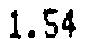

In [65]:
tdb_imgs[374]

In [66]:
refresh_main_db()

+------------------------------------------------------+-------------------------------------------------------------------------------------------------+
| Key                                                  | Value                                                                                           |
+------------------------------------------------------+-------------------------------------------------------------------------------------------------+
| d2gan_train_task12_crop50080_0002                    | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop50080_0002                    |
| d2gan_train_task12_crop_0000                         | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0000                         |
| d2gan_train_task12_crop_0001                         | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0001                         |
| d2gan_train_task12_crop_random_0001                  | /media/myungs

['raw_test_task12_img_txt_sample',
 'recog_train_task2_random_pad_sp_0003',
 'recog_inference_result_2497d6_raw_pad1',
 'inference_crop_0831_thr05_all_preview_detection',
 'raw_test_task12_img_txt_sample40',
 'recog_train_task2_random_pad_sp_0004',
 'd2gan_train_task12_crop50080_0002',
 'recog_train_task2_pad_sp_0003',
 'recog_train_task2_all_0001',
 'recog_train_task2_random_pad_sp_0001',
 'recog_inference_result_9ae078_raw_pad2',
 'raw_test_task12_img_txt_X51005230605',
 'raw_recog_inference_data_all_0001',
 'recog_inference_result_2497d6_raw_pad2',
 'recog_inference_result_d4637d_raw_pad7',
 'recog_train_task2_random_pad3_u80_0001',
 'recog_test_all_pad5_valid_0001',
 'recog_train_task2_random_pad3_u80_style_0002',
 'recog_inference_result_9ae078_raw_pad1',
 'raw_test_task12_img_txt_0001',
 'recog_train_task2_pad_sp_0002',
 'recog_inference_result_b15a8a_raw_pad3',
 'inference_crop_0901_thr05_sample40',
 'recog_inference_result_b15a8a_raw_pad2',
 'inference_crop_0831_thr05_sample40_